# Active Wells Forecasting

## Importing libraries

In [1]:
import pandas as pd
import warnings

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns

## Setting optios=ns

In [26]:
%matplotlib inline
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 5,6

In [21]:
ori=pd.read_csv('website_data_20190225.csv')
ori.drop(['STATE','DISTRICT','WLCODE','SITE_TYPE','TEH_NAME','LAT','LON','SITE_NAME','POMRB','POMKH','PREMON'],axis=1,inplace=True)
ori.replace(to_replace="'0",value=0,inplace=True)
ori.head()

,BLOCK_NAME,YEAR_OBS,MONSOON
0,Masuda,2016,13.23
1,Peesangan,2016,19.31
2,Arain,2016,5.45
3,Srinagar,2016,6.7
4,Jawaja,2016,4.12


In [22]:
dataset=pd.DataFrame().reindex_like(ori)
dataset.dropna(inplace=True)

# j=0
# for i in range(0,ori.shape[0]):
#     if ori['STATE'][i]=='RJ':
#         dataset.loc[j] = ori.iloc[i]
#         j+=1
# dataset.drop(['STATE'],axis=1,inplace=True)

# j=0
# for i in range(0,ori.shape[0]):
#     if ori['DISTRICT'][i]=='Ajmer':
#         dataset.loc[j] = ori.iloc[i]
#         j+=1
# dataset.drop(['DISTRICT'],axis=1,inplace=True)

j=0
for i in range(0,ori.shape[0]):
    if ori['BLOCK_NAME'][i]=='Arain':
        dataset.loc[j] = ori.iloc[i]
        j+=1
dataset.drop(['BLOCK_NAME'],axis=1,inplace=True)

dataset.head()

,YEAR_OBS,MONSOON
0,2016.0,5.45
1,2016.0,0
2,2016.0,2
3,2016.0,14.12
4,2016.0,4.45


In [23]:
dataset['YEAR_OBS']=(dataset['YEAR_OBS']).apply(np.int64)
dataset.rename(columns={'MONSOON':'No. Of Active Wells'}, inplace=True)
dataset.head()

,YEAR_OBS,No. Of Active Wells
0,2016,5.45
1,2016,0
2,2016,2
3,2016,14.12
4,2016,4.45


In [24]:
dataset['YEAR_OBS']=pd.to_datetime(dataset['YEAR_OBS'],yearfirst=True,format='%Y',infer_datetime_format=True)
indexedDataset=dataset.groupby('YEAR_OBS').count()

indexedDataset.head()

,No. Of Active Wells
YEAR_OBS,
1994-01-01,3
1995-01-01,3
1996-01-01,3
1997-01-01,3
1998-01-01,3


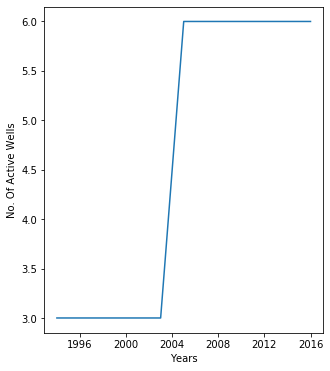

In [27]:
plt.xlabel('Years')
plt.ylabel('No. Of Active Wells')
plt.plot(indexedDataset);

In [52]:
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries):
    
    
    moving_average=timeseries.rolling(window=2).mean()
    standard_deviation=timeseries.rolling(window=2).std()
    
    plt.plot(timeseries,color='blue',label="Original")
    plt.plot(moving_average,color='red',label='Mean')
    plt.plot(standard_deviation,color='black',label='Standard Deviation')
    plt.legend(loc='best')  #best for axes
    plt.title('Rolling Mean & Deviation')
    plt.show(block=False)
    
    print('Results Of Dickey-Fuller Test')
    tstest=adfuller(timeseries.iloc[:, 0],autolag='AIC')
    tsoutput=pd.Series(tstest[0:4],index=['Test Statistcs','P-value','#Lags used',"#Obs. used"])
    for key,value in tstest[4].items():
        tsoutput['Critical Value (%s)'%key]=value
    print((tsoutput))

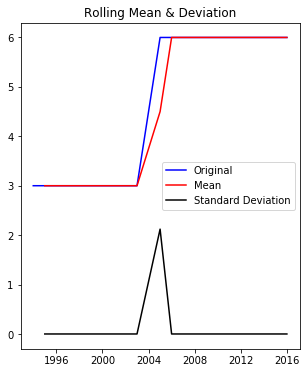

Results Of Dickey-Fuller Test
Test Statistcs          -1.051580
P-value                  0.733990
#Lags used               0.000000
#Obs. used              21.000000
Critical Value (1%)     -3.788386
Critical Value (5%)     -3.013098
Critical Value (10%)    -2.646397
dtype: float64


In [53]:
test_stationary(indexedDataset)

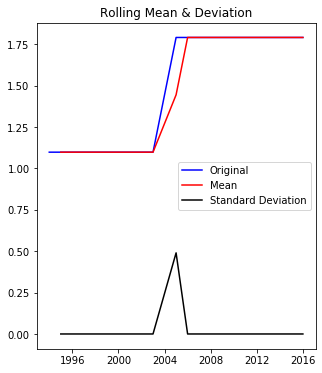

Results Of Dickey-Fuller Test
Test Statistcs          -1.051580
P-value                  0.733990
#Lags used               0.000000
#Obs. used              21.000000
Critical Value (1%)     -3.788386
Critical Value (5%)     -3.013098
Critical Value (10%)    -2.646397
dtype: float64


In [54]:
indexedDataset_logscale=np.log(indexedDataset)
test_stationary(indexedDataset_logscale)

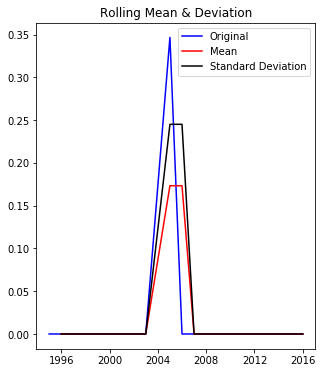

Results Of Dickey-Fuller Test
Test Statistcs          -4.472136
P-value                  0.000221
#Lags used               0.000000
#Obs. used              20.000000
Critical Value (1%)     -3.809209
Critical Value (5%)     -3.021645
Critical Value (10%)    -2.650713
dtype: float64


In [55]:
rolmeanlog=indexedDataset_logscale.rolling(window=2).mean()
dl_ma=indexedDataset_logscale-rolmeanlog
dl_ma.dropna(inplace=True)
test_stationary(dl_ma)

In [56]:
indexedDataset_logscale.head()

,No. Of Active Wells
YEAR_OBS,
1994-01-01,1.098612
1995-01-01,1.098612
1996-01-01,1.098612
1997-01-01,1.098612
1998-01-01,1.098612


In [57]:
rolmeanlog.head()

,No. Of Active Wells
YEAR_OBS,
1994-01-01,NaN
1995-01-01,1.098612
1996-01-01,1.098612
1997-01-01,1.098612
1998-01-01,1.098612


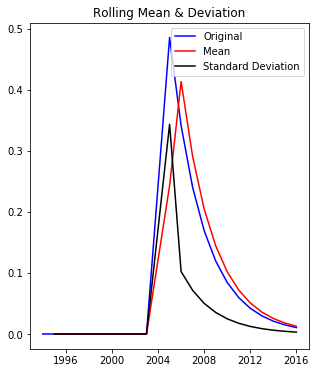

Results Of Dickey-Fuller Test
Test Statistcs          -4.252932
P-value                  0.000535
#Lags used               9.000000
#Obs. used              12.000000
Critical Value (1%)     -4.137829
Critical Value (5%)     -3.154972
Critical Value (10%)    -2.714477
dtype: float64


In [58]:
edwa=indexedDataset_logscale.ewm(halflife=2,min_periods=0,adjust=True).mean()
dlmeda=indexedDataset_logscale-edwa
test_stationary(dlmeda)

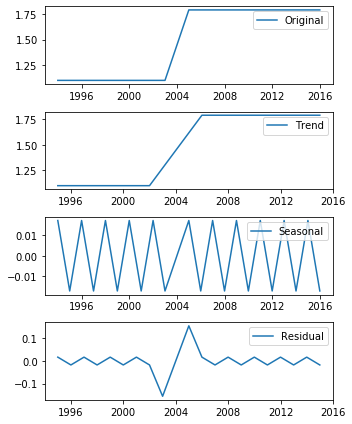

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompostion= seasonal_decompose(indexedDataset_logscale,freq=2)

trend=decompostion.trend
seasonal=decompostion.seasonal
residual=decompostion.resid

plt.subplot(411)
plt.plot(indexedDataset_logscale,label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')

plt.tight_layout()

In [60]:
decomposedlogdata=residual

In [61]:
decomposedlogdata.dropna(inplace=True)

In [64]:
pd.DataFrame(decomposedlogdata.astype('float32'))

,resid
YEAR_OBS,
1995-01-01,0.017329
1996-01-01,-0.017329
1997-01-01,0.017329
1998-01-01,-0.017329
1999-01-01,0.017329
2000-01-01,-0.017329
2001-01-01,0.017329
2002-01-01,-0.017329
2003-01-01,-0.155958


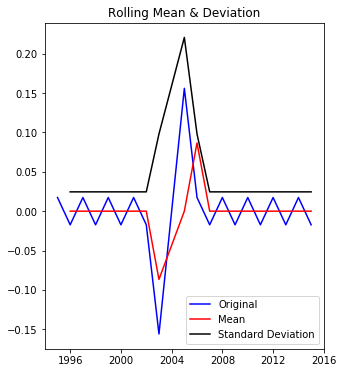

Results Of Dickey-Fuller Test
Test Statistcs          -1.190238
P-value                  0.677781
#Lags used               7.000000
#Obs. used              12.000000
Critical Value (1%)     -4.137829
Critical Value (5%)     -3.154972
Critical Value (10%)    -2.714477
dtype: float64


In [65]:
test_stationary(pd.DataFrame(decomposedlogdata.astype('float32')))

In [66]:
from statsmodels.tsa.stattools import acf,pacf
lag_acf=acf(dlds,nlags=20)
lag_pacf=pacf(dlds,nlags=20,method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dlds)),linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dlds)),linestyle='--',color='gray')
plt.title('AutoCorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(dlds)),linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dlds)),linestyle='--',color='gray')
plt.title('PartialAutoCorrelation Function')

plt.tight_layout()

NameError: name 'dlds' is not defined

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model=ARIMA(indexedDataset_logscale,order=(5,1,0))
results_AR=model.fit(disp=-1)
plt.plot(dlds)
plt.plot(results_AR.fittedvalues,color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues-dlds['No. Of Active Wells'])**2))
print('Plotting AR Model')

In [ ]:
model = ARIMA(indexedDataset_logscale, order=(0, 1, 5))  #0,1,2
results_MA = model.fit(disp=-1)  
plt.plot(dlds)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues-dlds['No. Of Active Wells'])**2))
print('Plotting MA Model')

In [ ]:
model = ARIMA(indexedDataset_logscale, order=(5, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(dlds)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues-dlds['No. Of Active Wells'])**2))
print('Plotting Combined Model')

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

In [ ]:
predictions_ARIMA_log = pd.Series(indexedDataset_logscale['No. Of Active Wells'].ix[0], index=indexedDataset_logscale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

In [ ]:
(predictions_ARIMA-indexedDataset['No. Of Active Wells'])

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-indexedDataset['No. Of Active Wells'])**2)/len(indexedDataset)))

In [ ]:
results_ARIMA.plot_predict(1,26)

In [ ]:
x=results_ARIMA.forecast(steps=5)
print(x)

In [ ]:
np.exp(results_ARIMA.forecast(steps=5)[0])